In [1]:
import pandas as pd
import math
import numpy as np
import os
global values
global val_to_int
global languages
global maxlen
global N_LANG
N_LANG=10
values='ABCDEFabcdef0123456789*'
val_to_int = dict((c, i) for i, c in enumerate(values))
languages=["hi","bn","gu","kn","mr","or","ta","te","ml","pa"]
languages.sort()
from re import sub
maxlen=32
import tensorflow as tf


In [2]:
def one_hot_encoded(data):
  integer_encoded=[]
  for i in range(len(data)):
    integer_encoded.append([val_to_int[char] for char in data[i]])
  one_hot_encoded = []   
  for i in integer_encoded:
    letter = np.zeros(len(values))
    for j in i:
      letter[j]=1
    one_hot_encoded.append(letter)
  while(len(one_hot_encoded)<maxlen):
    letter = np.zeros(len(values))
    one_hot_encoded.append(letter)
  return np.array(one_hot_encoded)

def generate_iscii_map():
  df=pd.read_csv('https://raw.githubusercontent.com/sonalgan/DeepLearning/master/iscii1.csv')
  lang_map=[]
  ls=dict()
  for lang in languages:
    ls=dict()
    for i,j in zip(df.iscii,df[lang]):
      if(j!=j):
        continue
      ls[j]=i
    lang_map.append(ls)
  return np.array(lang_map)


def process(data):
  iscii_encoded=[]
  data= re.sub(r"\d+","",data)
  #print(data)
  for ch in data:
    #print(ch)
    for x in lang_map:
      y=list(x.keys())
      #print(y)
      if(ch in y):
          iscii_encoded.append(x[ch].capitalize())
          break
  return iscii_encoded

def encode_labels(label):
    temp = np.zeros(N_LANG)
    i=languages.index(label)
    temp[i] = 1
    return temp

In [3]:
#df=pd.read_csv('./iscii1.csv',).fillna(value=0)


global lang_map
lang_map=generate_iscii_map()


In [4]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/tesla/code/Users/ganvir.sonal2000'

In [5]:

dirt='data'
root=os.getcwd()
try:
    os.mkdir(os.path.join(root,dirt))
except FileExistsError:
    pass
os.chdir(os.path.join(root,dirt))
print(os.getcwd())



/mnt/batch/tasks/shared/LS_root/mounts/clusters/tesla/code/Users/ganvir.sonal2000/data


In [6]:
    X=[]
    Y=[]
#path="https://hpedl.blob.core.windows.net/lang/"

    fp='https://raw.githubusercontent.com/sonalgan/DeepLearning/master/words.csv'
    #fp="{}.csv".format(lang)
    #!wget  -nc {path+fp}
    df=pd.read_csv(fp)
    print(fp)
    for x,y in zip(df.words,df.lang):
        if(pd.isna(x)):
              continue
        if(len(x)<=maxlen):
            X.append(one_hot_encoded(process(x)))
            Y.append(encode_labels(y))
    del df
    X=np.array(X)
    Y=np.array(Y)
'''
    for x in df[0]:
        if(pd.isna(x)):
              continue
        X.append(one_hot_encoded(process(x)))
        Y.append(lang)
    !rm {fp}
'''

https://raw.githubusercontent.com/sonalgan/DeepLearning/master/words.csv


'\nfor x in df[0]:\n    if(pd.isna(x)):\n          continue\n    X.append(one_hot_encoded(process(x)))\n    Y.append(lang)\n!rm {fp}\n'

In [7]:
X.shape

(100000, 32, 23)

In [8]:
Y.shape

(100000, 10)

###Data Distribution 

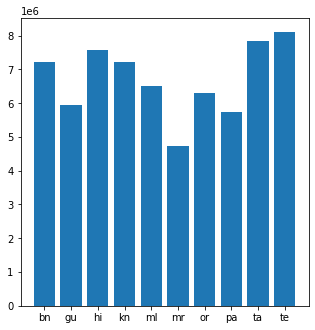

9.263880117655143
76


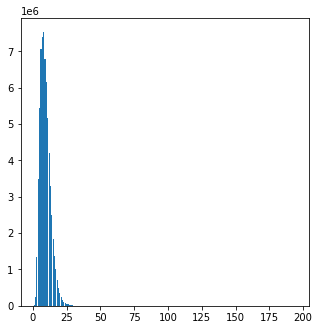

In [23]:



import matplotlib.pyplot as plt
from collections import Counter
counts=Counter(Y)
#counts=Counter(X)

fig=plt.figure(figsize=(4,4))
x,y=zip(*counts.items())
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()
counts=Counter(X)
sum_of_numbers = sum(number*count for number, count in counts.items())
count = sum(count for n, count in counts.items())
mean = sum_of_numbers / count
print(mean)
fig=plt.figure(figsize=(4,4))
x,y=zip(*counts.items())
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()



In [67]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [76]:
def getmodel():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(600, input_dim=23*maxlen, activation='sigmoid',kernel_constraint=maxnorm(4)))
    model.add(Dense(400, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(N_LANG, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
def generate_X_Y(data,labels):
    # Fit the model
    x=[]
    y=[]
    for i,j in zip(data, labels):
        x.append(one_hot_encoded(process(i)))
        y.append(encode_labels(j))
    return x,y
    

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) # 0.25 x 0.8 = 0.2

In [22]:
sizes=[0.10,0.15,0.20,0.25,0.30]
cvscores=[]
historys=[]
for size in sizes:
    print(size)
    X_train, X_test, y_train, y_test = train_test_split(X, Y,shuffle=True, test_size=size)
    model=getmodel()
    history=model.fit(X_train, y_train, epochs=100, batch_size=1024, callbacks=[es],verbose=0,shuffle=True)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100),model.metrics_names[0],scores[0])
    cvscores.append(scores[1] * 100)
    historys.append(history)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

0.1
accuracy: 93.78% loss 0.1662600569009781
0.15
accuracy: 93.25% loss 0.18347576971054078
0.2
accuracy: 93.65% loss 0.17142441487312318
0.25
accuracy: 93.55% loss 0.17419633105278015
0.3
accuracy: 93.30% loss 0.1815960068066915


NameError: name 'numpy' is not defined

# Grid Search

In [37]:
seed = 7
np.random.seed(seed)
# load dataset
# create model
model = KerasClassifier(build_fn=getmodel, epochs=100, batch_size=1024, verbose=0)
# define the grid search parameters
optimizer = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

param_grid = dict(optimizer=optimizer)
print(param_grid )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'optimizer': ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Best: 0.900001 using {'optimizer': 'sgd'}
0.900001 (0.000000) with: {'optimizer': 'sgd'}
0.859030 (0.007834) with: {'optimizer': 'rmsprop'}
0.857956 (0.005153) with: {'optimizer': 'adagrad'}
0.900001 (0.000000) with: {'optimizer': 'adadelta'}
0.854720 (0.010320) with: {'optimizer': 'adam'}
0.858289 (0.006534) with: {'optimizer': 'adamax'}
0.838831 (0.015135) with: {'optimizer': 'nadam'}


In [23]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

93.51% (+/- 0.20%)


In [ ]:
seed = 7
np.random.seed(seed)
# load dataset
# create mode
model = KerasClassifier(build_fn=getmodel, epochs=200, batch_size=1024, verbose=0)
# define the grid search parameters
optimizer = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

param_grid = dict(optimizer=optimizer)
print(param_grid )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=2)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'optimizer': ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']}
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


In [74]:
test_no=5

In [77]:
filepath = "./weights{}.hdf5".format(test_no)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
tboard = TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
callbacks_list = [checkpoint,es]
model=getmodel()
history=model.fit(X_train, y_train, epochs=300, batch_size=1024, validation_data=(X_val, y_val), callbacks=callbacks_list,verbose=1,shuffle=True)

Train on 81000 samples, validate on 9000 samples
Epoch 1/300
81000/81000 [==============================] - 3s 33us/step - loss: 0.3319 - accuracy: 0.8999 - val_loss: 0.3251 - val_accuracy: 0.9000

Epoch 00001: val_accuracy improved from -inf to 0.90000, saving model to ./weights5.hdf5
Epoch 2/300
81000/81000 [==============================] - 2s 26us/step - loss: 0.3255 - accuracy: 0.9000 - val_loss: 0.3251 - val_accuracy: 0.9000

Epoch 00002: val_accuracy did not improve from 0.90000
Epoch 3/300
81000/81000 [==============================] - 2s 26us/step - loss: 0.3252 - accuracy: 0.9000 - val_loss: 0.3251 - val_accuracy: 0.9000

Epoch 00003: val_accuracy did not improve from 0.90000
Epoch 4/300
81000/81000 [==============================] - 2s 26us/step - loss: 0.3252 - accuracy: 0.9000 - val_loss: 0.3251 - val_accuracy: 0.9000

Epoch 00004: val_accuracy did not improve from 0.90000
Epoch 5/300
81000/81000 [==============================] - 2s 26us/step - loss: 0.3251 - accuracy: 0.

In [79]:
print(model.predict_classes(X_test))
x=0
acc=0
for i,j in zip(model.predict_classes(X_test),y_test):
    #print(i,np.argmax(j))
    x+=1
    if(i==np.argmax(j)):
        acc+=1
print(acc,x)


[4 8 6 ... 4 7 4]
6468 10000


In [44]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir} --port 6006

In [31]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

1


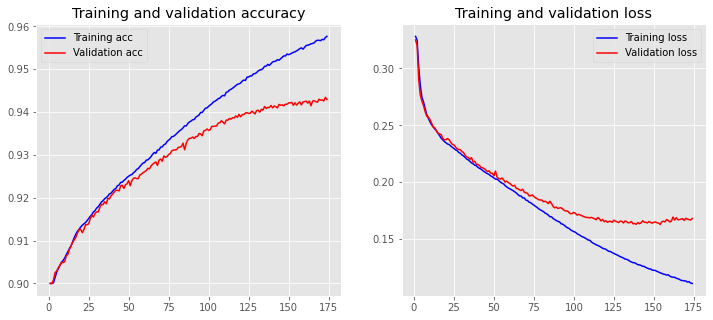

In [33]:
print(test_no)
plot_history(history)



In [40]:
model.save("model1.h5")

1


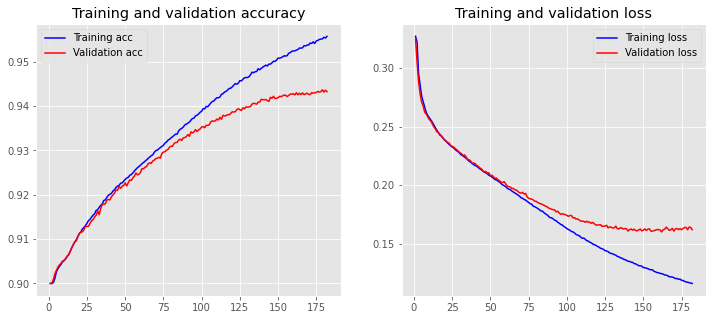

In [43]:
print(test_no)
plot_history(history)


2


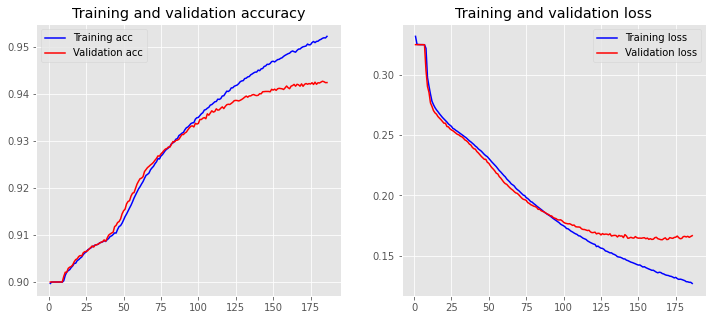

In [64]:
print(test_no)
plot_history(history)
model.save("model2.h5")

2


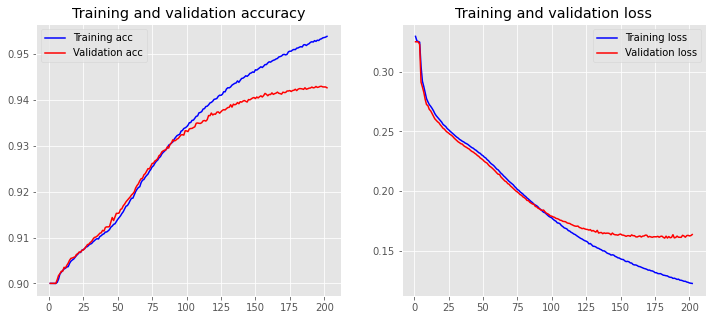

In [69]:
print(test_no)
plot_history(history)
model.save("model{}.h5".format(test_no))

5


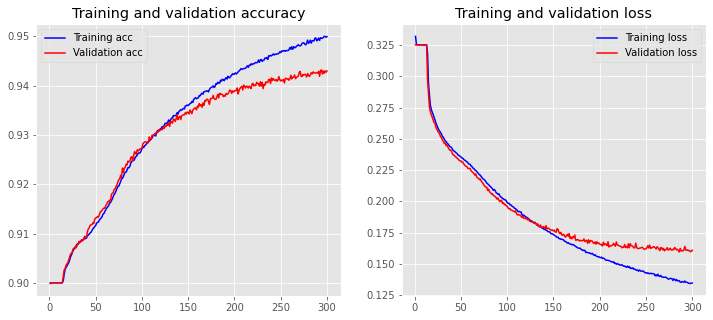

In [78]:
print(test_no)
plot_history(history)
model.save("model{}.h5".format(test_no))